In [1]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style(plot_style = False)

In [2]:
os.chdir(path)

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score

%watermark -a 'Ethen' -d -t -v -p numpy,matplotlib,sklearn

Ethen 2017-09-14 08:57:18 

CPython 3.5.2
IPython 6.1.0

numpy 1.13.1
matplotlib 2.0.0
sklearn 0.18.1


# Support Vector Machine (SVM)

We'll again start off by generating some toy data to work with:

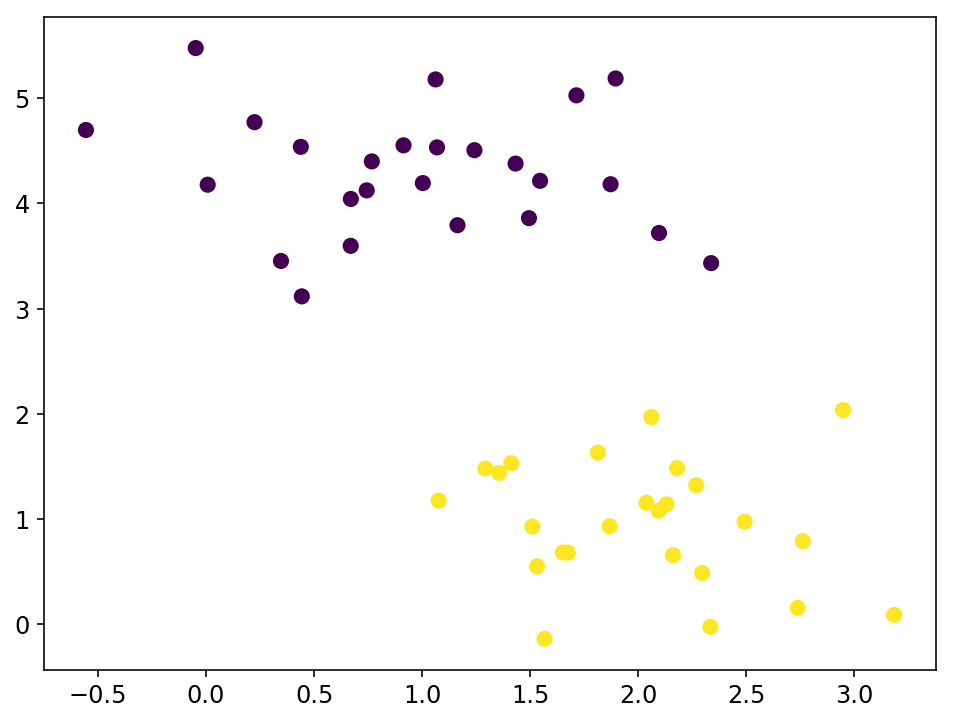

In [3]:
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

X, y = make_blobs(
    n_samples = 50, centers = 2, random_state = 0, cluster_std = 0.60)

plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)
plt.show()

Given the dataset, we wish to come up with an algorithm that separates the two classes and finding a line (in higher dimension, the line is more often referred to as a hyperplane) that passes between the two classes seems like a good choice, but immediately we realize that there's more than one line that can perfectly separate the two classes (See figure below).


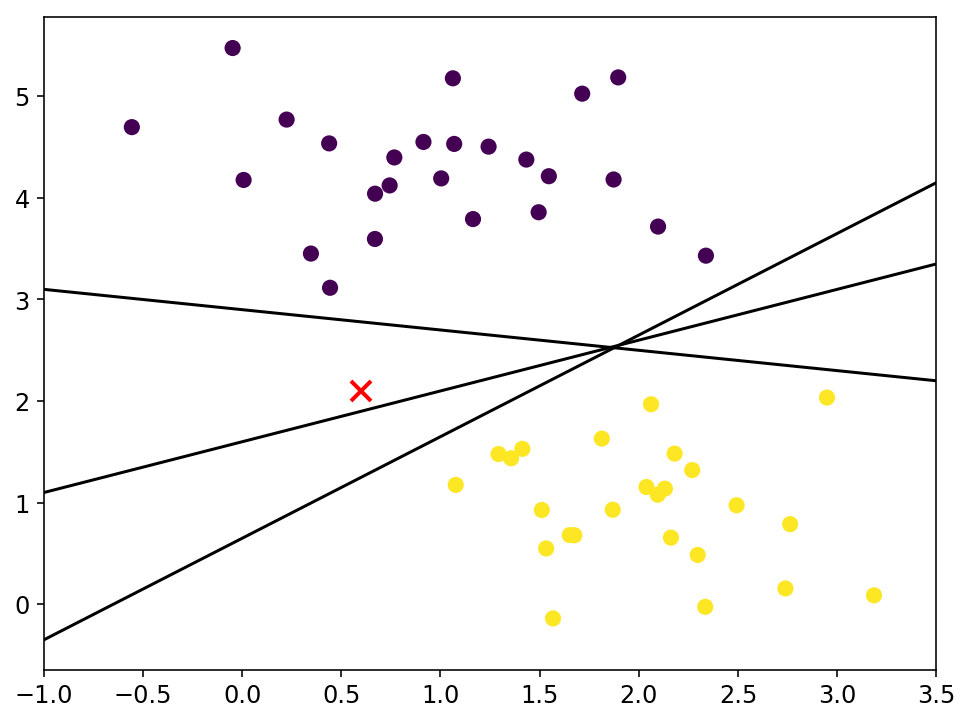

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)
plt.plot([0.6], [2.1], 'x', color = 'red', markeredgewidth = 2, markersize = 10)

# three possible candidates for a line that
# separates the two classes
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)
plt.show()

These are three valid separating hyperplanes which all successfully separate the samples from the two classes. Depending on which we choose, however, a new data point (e.g., the one marked by the "X" in this plot) will be assigned a different label! Thus, we need to think a bit deeper and find a line that's most suitable for the job.

**Support Vector Machines (SVM)** offers one way to find the most preferable line base on the training data we provide. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look like:

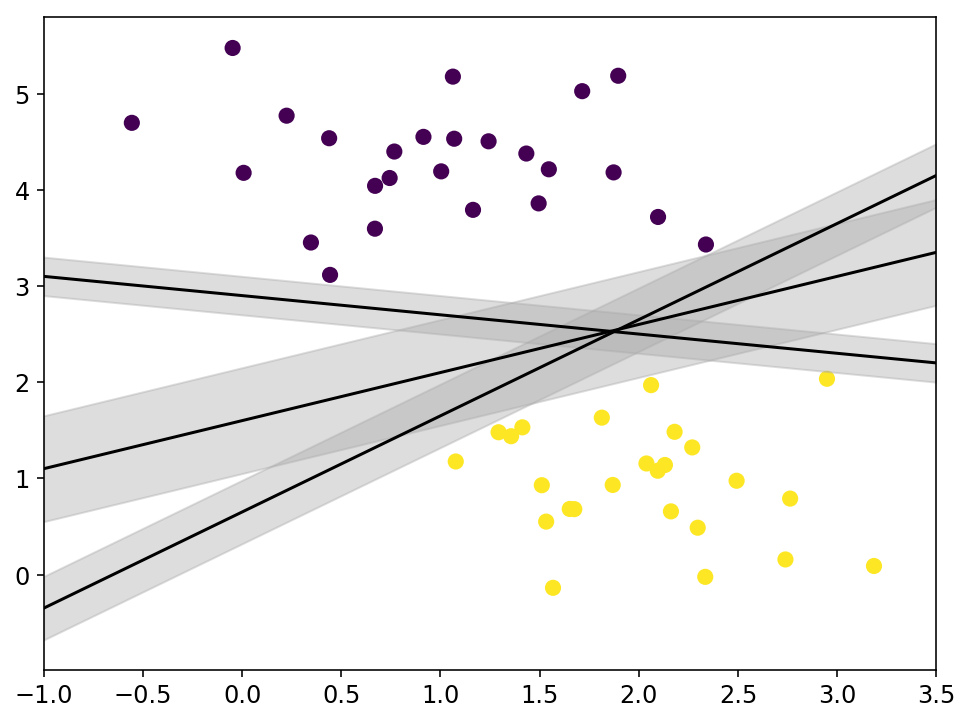

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)

# add a margin to the three candidates
for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor = 'none',
                     color = '#AAAAAA', alpha = 0.4)

plt.xlim(-1, 3.5)
plt.show()

In SVM, the line that maximizes this margin (width of the grey shaded area) is the one we will choose as the optimal model. In other words, the objective is to choose a line that's as far as possible from the data points of both classes to minimize the chance of making a mistake. Now that we understand SVM's goal is to find the hyperplane which maximizes the margin. The next question is, how do we calculate this margin?

Linear SVM classifier predicts the new class of a new observation $x$ by plugging it in to the hyperplane/decision function: $\mathbf{w}\cdot\mathbf{x} + b = 0$ if the result is positive than the predicted class, $\hat{y}$, will be the positive class and vice versa:

\begin{align}
\hat{y} =
\begin{cases}
   1 \text{ if } \mathbf{w}\cdot\mathbf{x} + b \geq 0 \\
   -1 \text{ if } \mathbf{w}\cdot\mathbf{x} + b < 0
\end{cases}
\end{align}

Notice that here our negative class is represented as -1. This is because now we can combine the two equations into one:

\begin{align}
y_i (\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1, \;\forall \;1\leq i \leq n
\end{align}

Apart from the hyperplane $\mathbf{w}\cdot\mathbf{x} + b = 0$ that separates the data, from the plot above, we can see that to construct the margin we also have the two hyperplane that separates our data $H_0$ and $H_1$, which can be denoted as:

\begin{align}
H_0 &: \mathbf{w}\cdot\mathbf{x} + b = -\delta \\
H_1 &: \mathbf{w}\cdot\mathbf{x} + b = \delta
\end{align}

However, here the variable $\delta$ is not necessary. So we can safely set it to 1 to simplify the problem (more on this later), hence we end up with:

\begin{align}
H_0 &: \mathbf{w}\cdot\mathbf{x} + b = -1 \\
H_1 &: \mathbf{w}\cdot\mathbf{x} + b = 1
\end{align}

Recall that the goal of SVM is to find the hyperplane that maximizes the margin, and this is equivalent to maximizing the distance between the two hyperplane $H_0$ and $H_1$. To make this a bit concrete, let's look at the diagram below:

<img src="img/margin1.png" width="55%" height="55%">

Let's assume that $x_0$ is a point on $H_0$, We will use $m$ to denote the perpendicular distance from $x_0$ to the hyperplane $H_1$. As $x_0$ is on $H_0$, $m$ is the distance between the two hyperplanes and this is by definition the margin that we're interested in.

The initial thought might be, if we add $m$ to $x_0$ we will get another point, and this point will be on the other hyperplane and we can then compute the distance between the two points to obtain the margin. But it does not work, because $m$ is a scalar, and $x_0$ is a vector and adding a scalar with a vector is not possible. However, we know that adding two vectors is possible, so if we transform $m$ into a vector we will be able to do an addition. In other words, our temporary goal is to complete the equation $\textbf{z}_0 = \textbf{x}_0 + \textbf{k}$, where $\textbf{z}_0$ is the point on the $H_1$ hyperplane and $\textbf{k}$ is the vector that would complete the vector addition:

<img src="img/margin2.png" width="55%" height="55%">

To complete this equation, we know our vector $\textbf{k}$ needs to have two properties:

- Have a magnitude of $m$, the margin.
- Be perpendicular to the hyperplane $H_1$

Fortunately, given that $H_1 : \mathbf{w}\cdot\mathbf{x} + b = 1$ we already know our vector $\mathbf{w}$ is perpendicular to $H_1$

<img src="img/margin3.png" width="55%" height="55%">

Now, we can first scale $\mathbf{w}$ back to a unit vector and multiply it with $m$ to get our targeted vector $\textbf{k}$

\begin{align}
\textbf{k} &= m\frac{\textbf{w}}{\| \textbf{w} \|}
\end{align}

Given this information we can now derive the formula for our margin $m$. Given that $\textbf{z}_0$ is on the hyperplane $H_1 : \mathbf{w}\cdot\mathbf{x} + b = 1$ and $\textbf{x}_0$ is on the hyperplane $H_0 : \mathbf{w}\cdot\mathbf{x} + b = -1$:

\begin{align}
\textbf{w} \cdot \textbf{z}_0 + b = 1 
&= \textbf{w} \cdot (\textbf{x}_0 + \textbf{k}) + b = 1 \\
&= \textbf{w} \cdot (\textbf{x}_0 + m\frac{\textbf{w}}{\| \textbf{w} \|}) + b = 1 \\
&= \textbf{w} \cdot \textbf{x}_0 + m\frac{\textbf{w} \cdot \textbf{w}}{\| \textbf{w} \|} + b = 1 \\
&= \textbf{w} \cdot \textbf{x}_0 + m\| \textbf{w} \| + b = 1 \\
&= \textbf{w}\cdot\textbf{x}_0 + b = 1 - m\|\textbf{w}\| \\
&= -1= 1 - m\| \textbf{w} \| \\
&= m = \frac{2}{\|\textbf{w}\|}
\end{align}

Looking at this formula for computing the margin, there's two things that we should be aware of:

1. Recall that a while ago, we said that for the hyperplanes, the parameter $\delta$ can be safely set to 1. Judging from the formula, we can see that the exact value of $\delta$ is in some sense meaningless as it is a multiplicative constant to the margin, and our denominator can simply shrink or stretch accordingly.
2. We see that the only variable we can change is the norm of $\textbf{w}$, $\|\textbf{w}\|$, this property is saying that maximizing the margin is equivalent to minimizing $\|\textbf{w}\|$. And instead of minimizing $\|\textbf{w}\|$, we will instead minimize $\frac{1}{2}\|\textbf{w}\|^2$ (again it's simply scaling it up by a factor), which will give us a nicer equation to work with when performing the actual optimization.

To sum it up, we now have the optimization problem for SVM:

\begin{align}
&  \underset{\mathbf{w, b}}{\text{minimize}}
&& \frac{1}{2}\|\textbf{w}\|^2 \nonumber \\
&  \text{subject to}
&& y_i (\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1\;, \forall \;1\leq i \leq n
\end{align}

Among all possible hyperplanes that satisfies the constraint, we will choose the one that minimizes the objective function and this maximal margin classifier is a very nice way to perform classification. In most real world cases, however, no such separating hyperplanes exists due to the fact that real world dataset are usually not linearly separable:

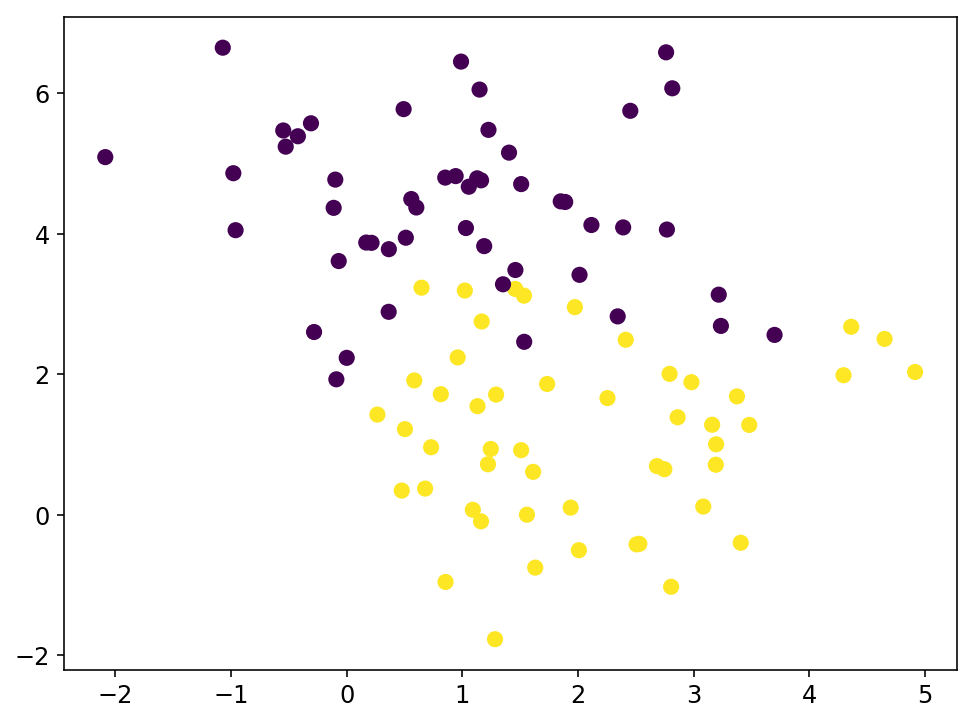

In [6]:
X, y = make_blobs(
    n_samples = 100, centers = 2, random_state = 0, cluster_std = 1.2)

# instead of being linearly separable,
# our data now has some amount of overlap
plt.scatter(X[:, 0], X[:, 1], c = y, s = 50)
plt.show()

Thus to make the algorithm work for non-linearly separable datasets, we need to extend the hard-margin objective function to a soft-margin objective function:

\begin{align}
&  \underset{\mathbf{w, b}}{\text{minimize}}
&& \frac{1}{2}\|\textbf{w}\|^2 + C \sum_i^n \zeta_i \nonumber \\
&  \text{subject to}
&& y_i (\mathbf{w} \cdot \mathbf{x}_i + b) \geq 1 - \zeta_i \; and \; \zeta_i \geq 0 \;, \forall \;1\leq i \leq n
\end{align}

- The rationale behind this extension is that, we will allows some of the points to creep into the margin if that allows a better fit. Looking at the constraint, we can see that datapoints can now have a margin that's less than 1, but whenever this happens, we would pay a cost of the objective function being increased by $C \cdot \zeta_i$.
- The $C$ is the cost parameter that controls the tradeoff between the twin goals of making $\frac{1}{2}\|\textbf{w}\|^2$ small (which we saw earlier makes the margin large) and of ensuring that most examples have functional margin at least 1. The optimal value of the parameter $C$ will depend on our dataset, and should be tuned using cross-validation or a similar procedure.

## Hinge Loss

To solve for the equation above, one way is to refactor the equation a bit and solve it using gradient descent like methods.

\begin{align}
L(w, b) &= \frac{1}{2}\|\textbf{w}\|^2 + C \sum_i^n max(0, 1 - y_i (\mathbf{w} \cdot \mathbf{x}_i + b))
\end{align}

- The second term is basically swapping the $\zeta$ with the formula in the subject to section and it quantifies the sum of all margin violations. An observation's margin violation is proportional to the distance it is to the correct side of the hyperplane and if it's on the correct side of the hyperplane than the cost will be 0. Minimizing this term ensures that the model makes the margin violations as small as possible.
- Hopefully, the first term looks familiar to you. It's essentially the [regularization term](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/regularization/regularization.ipynb) for our weights. We can divide the expression with $C$ and now $\frac{1}{C}$ is the l2-regularization strength that we can tune.

A last piece of terminology we’ll mention before we finish with this section is that the threshold at zero $max(0,−)$ function is often referred to as the **hinge loss**. Sometimes, you'll hear about people use the squared hinge loss (or L2-SVM), which uses the form $max(0,−)^2$ that penalizes violated margins more strongly (quadratically instead of linearly). The unsquared version is more standard, but in some datasets the squared hinge loss can work better. This again can be determined during cross-validation.

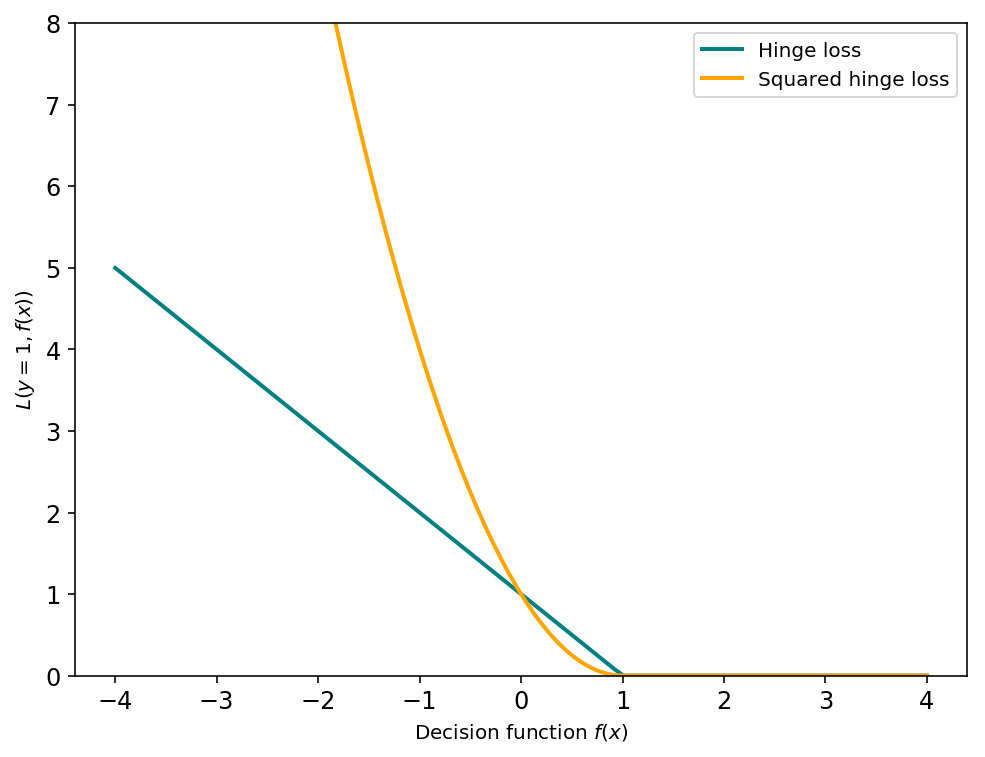

In [7]:
lw = 2
xmin, xmax = -4, 4
x = np.linspace(xmin, xmax, 100)

plt.plot(x, np.where(x < 1, 1 - x, 0), color = 'teal', lw = lw,
         label = 'Hinge loss')
plt.plot(x, np.where(x < 1, 1 - x, 0) ** 2, color = 'orange', lw = lw,
         label = 'Squared hinge loss')
plt.ylim((0, 8))
plt.legend(loc = 'upper right')
plt.xlabel('Decision function $f(x)$')
plt.ylabel('$L(y=1, f(x))$')
plt.show()

## Multiclass SVM

So far our discussion of SVM has been focusing on finding the optimal separating hyperplane between binary classes, we will now generalize it so it can so be used for multiclass SVM.

\begin{align}
L_i(w, b) = \sum_{j\neq y_i} \max(0, \mathbf{w}_j \cdot \mathbf{x}_i - \mathbf{w}_{y_i} \cdot \mathbf{x}_i + 1)
\end{align}

- For the i-th oberservation we are given the feature $x_i$ and the label $y_i$ that specifies the index of the correct class. 
- $j$ iterates over all $C$ classes hence $\mathbf{w}_j$ is the weights vector for computing the score of class $j$.

Let's unpack this with an example to see how it works. Suppose that we have three classes that receive the scores $s = [13, −7, 12.5]$, and that the first class is the true class (i.e. $y_i = 0$). The expression above sums over all incorrect classes ($j \neq y_i$), so we get two terms:

\begin{align}
L_i(w, b) = max(0, −7 − 13 + 1) + max(0, 12.5 − 13 + 1)
\end{align}

You can see that the first term gives zero since [-7 - 13 + 1] gives a negative number, which is then thresholded to zero with the $max(0,−)$ function. We get zero loss for this pair because the correct class score (13) was greater than the incorrect class score (-7) by at least 1. In fact the difference was 20, which is much greater than 1 but the SVM only cares that the difference is at least 1; Any additional difference above the margin is clamped at zero with the max operation. The second term computes [12.5 - 13 + 1] which gives 0.5. That is, even though the correct class had a higher score than the incorrect class (13 > 12.5), it was not greater by the desired margin of 1. The difference was only 0.5, which is why the loss comes out to 0.5 (i.e. how much higher the difference would have to be to meet the margin).

> In sum, SVM wants score, $\mathbf{w}_{y_i} \cdot \mathbf{x}_i$, of the correct class, $y_i$, to be greater than any other classes, $\mathbf{w}_j \cdot \mathbf{x}_i$, by at least a margin of 1 such that the loss becomes zero (clamped with the max operation).

By plugging back the regularization term and summing the loss across all observations, we arrive at:

\begin{align}
L(w, b) &=
\underbrace{ \frac{1}{n} \sum_i^n \sum_{j\neq y_i} \max(0, \mathbf{w}_j \cdot \mathbf{x}_i - \mathbf{w}_{y_i} \cdot \mathbf{x}_i + 1) }_\text{data loss} +
\underbrace{ \frac{\lambda}{2}\|\textbf{w}\|^2 }_\text{regularization loss}
\end{align}

$\frac{\lambda}{2}$ is the more common form of expressing regularization term instead of $\frac{1}{2C}$


## Implementation

To use gradient descent to solve for the objective function, we of course need the gradient (differentiate the loss with respect to $\textbf{w}$ of each class).

\begin{align}
\nabla_{w} L_i 
&=
  \begin{bmatrix}
    \frac{dL_i}{dw_1} & \frac{dL_i}{dw_2} & \cdots & \frac{dL_i}{dw_C} 
  \end{bmatrix}
= 
  \begin{bmatrix}
    \frac{dL_i}{dw_{11}} & \frac{dL_i}{dw_{21}} & \cdots & \frac{dL_i}{dw_{y_i1}} & \cdots & \frac{dL_i}{dw_{C1}} \\
    \vdots & \ddots \\
    \frac{dL_i}{dw_{1D}} & \frac{dL_i}{dw_{2D}} & \cdots & \frac{dL_i}{dw_{y_iD}} & \cdots & \frac{dL_i}{dw_{CD}} 
  \end{bmatrix}
\end{align}

Where $D$ represents the number of dimensions/features in the dataset. There are two different cases: when $j \neq y_i$ and $j = y_i$. We'll start with $j \neq y_i$ and the sub-gradient for the term $\frac{dL_i}{dw_{11}}$ first:

\begin{align}
L_i = 
&\max(0, w_{11}x_{i1} + w_{12}x_{i2} \ldots + w_{1D}x_{iD} - w_{y_i1}x_{i1} - w_{y_i2}x_{i2} \ldots - w_{y_iD}x_{iD} + 1) + \nonumber \\
&\max(0, w_{21}x_{i1} + w_{22}x_{i2} \ldots + w_{2D}x_{iD} - w_{y_i1}x_{i1} - w_{y_i2}x_{i2} \ldots - w_{y_iD}x_{iD} + 1) + \nonumber \\
&\quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \quad \vdots \nonumber \\
&\max(0, w_{C1}x_{i1} + w_{C2}x_{i2} \ldots + w_{CD}x_{iD} - w_{y_i1}x_{i1} - w_{y_i2}x_{i2} \ldots - w_{y_iD}x_{iD} + 1)
\end{align}

For the expression above, when $(w_1x_i - w_{y_i}x_i + 1) > 0$, we obtain 

\begin{align}
\frac{dL_i}{dw_{11}} = x_{i1}
\end{align}

The same notion can be applied to $w_{12}$ and $w_{13}$ ... and the case when $j = y_i$, giving us:


\begin{align}
\frac{\partial L_i}{\partial w} &=
\begin{cases}
\frac{\partial L_i}{\partial w_j} = \mathbb{1}(\mathbf{w}_j \cdot \mathbf{x}_i - \mathbf{w}_{y_i} \cdot \mathbf{x}_i + 1 > 0) x_i, \; if \; j \neq y_i \\
\frac{\partial L_i}{\partial w_{y_i}} = -\mathbb{1}(\mathbf{w}_j \cdot \mathbf{x}_i - \mathbf{w}_{y_i} \cdot \mathbf{x}_i + 1 > 0) x_i, \; if \; j = y_i
\end{cases}
\end{align}

Where $\mathbb{1}$ is the indicator function that is one if the condition inside is true or zero otherwise. While the expression may look scary when it is written out, when we're implementing this in code we are essentially counting the number of classes that didn't meet the desired margin (and hence contributed to the loss function) and then the data vector $x_i$ scaled by this number will be the gradient.

In [37]:
class SVM:
    """
    Multi-class Support Vector Machines (SVM) using gradient descent

    Parameters
    ----------
    learning_rate : float, default 0.01
        Learning rate for optimization.

    reg : float, default 0.01
        Regularization strength.

    n_iters : int, 100
        Number of iteration to run the optimization.

    Attributes
    ----------
    self.history_ : list
        Loss function at each iteration.

    self.weight_ : 2d ndarray, shape [n_features, n_classes]
        Weight for the svm model.
    """

    def __init__(self, learning_rate = 0.01, reg = 0.01, n_iters = 100):
        self.reg = reg
        self.n_iters = n_iters
        self.learning_rate = learning_rate

    def fit(self, X, y):
        """
        Fit the SVM model according to the given training data.

        Parameters
        ----------
        X : 2d ndarray, shape [n_samples, n_features]
            Training vectors, where n_samples is the number of samples
            and n_features is the number of features

        y : 1d ndarray, shape [n_samples]
            Target values (class labels in classification)
        """
        n_features = X.shape[1]
        n_classes = np.unique(y).shape[0]
        self.weight_ = np.random.randn(n_features, n_classes) * 0.01

        # run gradient descent to optimize W
        self.history_ = []
        for _ in range(self.n_iters):
            loss, gradient = self._loss(X, y)
            self.history_.append(loss)
            self.weight_ -= self.learning_rate * gradient

        return self

    def _loss(self, X, y):
        """Evaluate loss and gradient"""

        # scores shape: [sample, class]
        # every samples' score for every class
        n_samples = X.shape[0]
        scores = np.dot(X, self.weight_)

        # obtain the labeled class scores for each sample
        correct_scores = scores[range(n_samples), y]

        # sum up all the margin errors for the data loss
        # remember that we shouldn't count the j = y_i term (set it back to 0)
        margin = np.maximum(0, scores - correct_scores[:, np.newaxis] + 1)
        margin[range(n_samples), y] = 0

        loss_data = np.sum(margin) / n_samples
        loss_reg = 0.5 * self.reg * np.sum(self.weight_ ** 2)
        loss = loss_data + loss_reg

        # for j != y_i, it's a indicator function of
        # whether its margin is greater than 1
        gradient = np.zeros(scores.shape)
        gradient[margin > 0] = 1

        # for j = y_i
        # number of times that the margin is greater than 0
        count = np.sum(gradient, axis = 1)
        gradient[range(n_samples), y] = -count

        gradient_data = np.dot(X.T, gradient) / n_samples
        gradient_reg = self.reg * self.weight_
        gradient = gradient_data + gradient_reg
        return loss, gradient

    def predict(self, X):
        """
        Prediction of class labels on the input data using the trained model

        Parameters
        ----------
        X : 2d ndarray, shape [n_samples, n_features]
            Input data, where n_samples is the number of samples
            and n_features is the number of features

        Returns
        -------
        y_pred : 1d ndarray, shape [n_samples]
            Predicted labels for the input data
        """
        score = np.dot(X, self.weight_)
        y_pred = np.argmax(score, axis = 1)
        return y_pred

In [38]:
our_svm = SVM(n_iters = 200)
our_svm.fit(X, y)
our_svm_pred = our_svm.predict(X)
accuracy_score(y, our_svm_pred)

0.83999999999999997

In [40]:
# use sklearn's to confirm results are comparable
svm = LinearSVC(loss = 'hinge', C = 0.005)
svm.fit(X, y)
svm_pred = svm.predict(X)
accuracy_score(y, svm_pred)

0.83999999999999997

1. Platt Scaling?
2. Decision function
3. Support vector

In [ ]:
svm.decision_function(X)

In [ ]:
hi

In [ ]:
decision_function = X.dot(svm.coef_.T) + svm.intercept_

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline((
    ("scaler", scaler),
    ("linear_svc", svm_clf1),
))
scaled_svm_clf2 = Pipeline((
    ("scaler", scaler),
    ("linear_svc", svm_clf2),
))

svm_clf = Pipeline((
    ("scaler", StandardScaler()),
    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
))

svm_clf.fit(X, y)
scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

In [ ]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [ ]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

In [ ]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

# Reference

- [Blog: SVM Tutorial](https://www.svm-tutorial.com/)
- [Blog: Vectorized Implementation of SVM Loss and Gradient Update](https://mlxai.github.io/2017/01/06/vectorized-implementation-of-svm-loss-and-gradient-update.html)
- [Notes: CS231n Optimization 1](http://cs231n.github.io/optimization-1/)
- [Notes: CS231n Linear Classification](http://cs231n.github.io/linear-classify/)
- [Notebook: In-Depth: Support Vector Machines](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.07-Support-Vector-Machines.ipynb)